# Projective Camera Example


This example shows how to design and apply a 3D geometrical image processing pipeline.
Let's start with our 3D environment. It contains a house.

## Setting up the 3D environment

Our house will be stored into the variables X_inhom ($\tilde{X}$, inhomogeneous representation) and X ($X$, homogeneous representation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)

X_inhom = np.array([
    [1, 1, 0],
    [2, 1, 0],
    [2, 2, 0],
    [1, 2, 0],
    [1, 1, 1],
    [2, 1, 1],
    [2, 2, 1],
    [1, 2, 1],
    [1.5, 1.5, 2.5]
], dtype=np.float)
print(X_inhom)

[[1.  1.  0. ]
 [2.  1.  0. ]
 [2.  2.  0. ]
 [1.  2.  0. ]
 [1.  1.  1. ]
 [2.  1.  1. ]
 [2.  2.  1. ]
 [1.  2.  1. ]
 [1.5 1.5 2.5]]


In [2]:
X_inhom = X_inhom.T # take the transpose
print(X_inhom)
print("Shape of X_inhom:", X_inhom.shape)

[[1.  2.  2.  1.  1.  2.  2.  1.  1.5]
 [1.  1.  2.  2.  1.  1.  2.  2.  1.5]
 [0.  0.  0.  0.  1.  1.  1.  1.  2.5]]
Shape of X_inhom: (3, 9)


In [3]:
ones_row_num_rows = 1
ones_row_num_cols = X_inhom.shape[1]
ones_row_shape = (ones_row_num_rows, ones_row_num_cols)
ones_row = np.ones(ones_row_shape, dtype=np.float)

X = np.concatenate([X_inhom, ones_row])
print("X is:")
print(X)

X is:
[[1.  2.  2.  1.  1.  2.  2.  1.  1.5]
 [1.  1.  2.  2.  1.  1.  2.  2.  1.5]
 [0.  0.  0.  0.  1.  1.  1.  1.  2.5]
 [1.  1.  1.  1.  1.  1.  1.  1.  1. ]]


Let's define some connections (lines)...

In [8]:
connections = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 4],
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7],
    [4, 8],
    [5, 8],
    [6, 8],
    [7, 8]
])

## Setting up the Projective Camera
We model the camera EOS 90D with ajusted focal length to $18$ mm.
For that, we need to define the intrinsic and extrinsic parameters.

### Intrinsic Parameters
Well known parameters from manual:

In [9]:
# resolution: width x height = 6940 x 4640
w = 6940
h = 4640

# physical focal length
f_phys = 0.018 # 18 mm

# CMOS chip size
w_chip = 22.3 * 1e-3 # 22.3 mm
h_chip = 14.9 * 1e-3 # 14.9 mm

Calculate the pixel densities.

In [10]:
m_x = w / w_chip # unti: "pixel"/m
m_y = h / h_chip # unti: "pixel"/m
print("m_x is", m_x, "1/m = ", m_x / 1000, "1/mm")
print("m_y is", m_y, "1/m = ", m_x / 1000, "1/mm")

m_x is 311210.76233183854 1/m =  311.21076233183857 1/mm
m_y is 311409.39597315434 1/m =  311.21076233183857 1/mm


Calculate the remaining parameters needed for the $K$ matrix.

In [11]:
# focal length transplated to pixel space
f_x = f_phys * m_x # unit: "pixel" (unitless)
f_y = f_phys * m_y # unit: "pixel" (unitless)
print("f_x is:", f_x)
print("f_y is:", f_y)

# image center (distortion center) assumed to be exacly in the middle of the image plane.
c_x = (w + 1) / 2
c_y = (h + 1) / 2
print("c_x is:", c_x)
print("c_y is:", c_y)

# skew parameter assumed to be 0.
s = 0
print("s   is:", s)

# camera matrix K:
K = np.array([
    [f_x,   s, c_x],
    [  0, f_y, c_y],
    [  0,   0,   1]
], dtype=np.float)
print("K is:")
print(K)

f_x is: 5601.793721973093
f_y is: 5605.369127516778
c_x is: 3470.5
c_y is: 2320.5
s   is: 0
K is:
[[5601.794    0.    3470.5  ]
 [   0.    5605.369 2320.5  ]
 [   0.       0.       1.   ]]


### Extrinsic Parameters

In order to make a photograph from our hosue, we place our camera into the 3D scene.
We need to define the position $C$ and the orientation / rotation $R$.

In [12]:
# position
C = np.array([
    [0, -10, 4]
])
C = C.T

It is easier to set up a rotation matrix by defining its components.
*One* way to rotate into a certain direction is to rotate sequentially around the x axis, then y axis and lastly the z axis.
  
$\tilde{X'} = R_x \cdot \tilde{X}$  
$\tilde{X''} = R_y \cdot \tilde{X'}$  
$\tilde{X'''} = R_z \cdot \tilde{X''}$  
  
$\tilde{X'''} = R_z \cdot R_y \cdot R_x \cdot \tilde{X}$  
$\tilde{X'''} = R_{xyz} \cdot \tilde{X}$  

whereas...  
  
$R_x = \begin{bmatrix}
    1 & 0 & 0 \\
    0 & \cos(\alpha) & -\sin(\alpha) \\
    0 & \sin(\alpha) & \cos(\alpha) \\
\end{bmatrix}
\qquad
R_y = \begin{bmatrix}
    \cos(\beta) & 0 & \sin(\beta) \\
    0 & 1 & 0 \\
    -\sin(\beta) & 0 & \cos(\beta) \\
\end{bmatrix}
\qquad
R_z = \begin{bmatrix}
    \cos(\gamma) & -\sin(\gamma) & 0 \\
    \sin(\gamma) & \cos(\gamma) & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
$

In [13]:

# orientation / rotation
alpha_degrees = -90 # first:  rotate about alpha degrees around the camera's x-axis
beta_degrees  =  10 # second: rotate about beta  degrees around the camera's y-axis
gamma_degrees =   0 # third:  rotate about gamma degrees around the camera's z-axis

# into radians...
alpha = alpha_degrees * np.pi / 180
beta  = beta_degrees  * np.pi / 180
gamma = gamma_degrees * np.pi / 180

# prepare sine and cosine values
ca = np.cos(alpha)
sa = np.sin(alpha)
cb = np.cos(beta)
sb = np.sin(beta)
cg = np.cos(gamma)
sg = np.sin(gamma)

# rotation about x axis
R_x = np.array([
    [1,  0,   0],
    [0, ca, -sa],
    [0, sa,  ca],
], dtype=np.float)

# rotation about y axis
R_y = np.array([
    [ cb, 0, sb],
    [  0, 1,  0],
    [-sb, 0, cb]    
], dtype=np.float)

# rotation about z axis
R_z = np.array([
    [cg, -sg, 0],
    [sg,  cg, 0],
    [ 0,   0, 1]    
], dtype=np.float)

# compose R_xyz
R = R_z.dot(R_y.dot(R_x))

print("R is:")
print(R)


R is:
[[ 0.985 -0.174  0.   ]
 [ 0.     0.     1.   ]
 [-0.174 -0.985  0.   ]]


### Compose the camera projection matrix

Now we can compose the camera projection matrix $P$.  
Remeber:  
$P = K \cdot R \cdot \begin{bmatrix}I & -C\end{bmatrix}_{3 \times 4}$
  
This can be rewritten to:  
$P = \begin{bmatrix}KR & -KRC\end{bmatrix}_{3 \times 4}$  
$P = \begin{bmatrix}M & -MC\end{bmatrix}_{3 \times 4}$  


In [14]:
M = K.dot(R)
MC = M.dot(C)

P = np.concatenate([M, -MC], axis=1)
# axis 1 means concatenate in 2nd dim (horizontaly)
# axis 0 would mean concatenate in 1st dim (vertically)

print("P is: ")
print(P)

P is: 
[[  4914.044  -4390.517      0.    -43905.166]
 [  -402.951  -2285.246   5605.369 -45273.94 ]
 [    -0.174     -0.985      0.        -9.848]]


# Making the photograph

We shoot a photograph by applying the geometrical imaging processing pipeline.

In [15]:
X_img = P.dot(X)
print("X_img is:", X_img)

X_img is: [[-43381.638 -38467.595 -42858.111 -47772.155 -43381.638 -38467.595
  -42858.111 -47772.155 -43119.875]
 [-47962.137 -48365.088 -50650.334 -50247.384 -42356.768 -42759.719
  -45044.965 -44642.015 -35292.813]
 [   -11.007    -11.18     -12.165    -11.991    -11.007    -11.18
     -12.165    -11.991    -11.586]]


Let's make the image plane visible.  
**BTW: You do not have to plot in the examination.**

In [16]:
X_img_inhom = X_img[:2, :] / X_img[2, :]

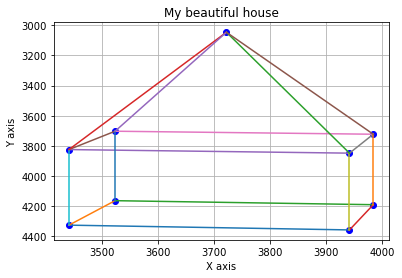

In [17]:
# generate new figure
fig, ax = plt.subplots()

# draw edges on canvas
ax.plot(X_img_inhom[0, :], X_img_inhom[1, :], 'bo')

# draw line by line
num_connections = connections.shape[0]
for i in range(num_connections):
    start_point_idx = connections[i, 0]
    start_x = X_img_inhom[0, start_point_idx]
    start_y = X_img_inhom[1, start_point_idx]
    
    end_point_idx = connections[i, 1]
    end_x = X_img_inhom[0, end_point_idx]
    end_y = X_img_inhom[1, end_point_idx]
    
    ax.plot([start_x, end_x], [start_y, end_y])


# invert matplotlib's y axis (it has to point downwards)
ax.invert_yaxis()

# axis labeling
ax.set(xlabel='X axis', ylabel='Y axis',
       title='My beautiful house')

# misc
ax.grid()

# show the plot
plt.show()